#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/home/franko/anaconda3/envs/critical/bin/python


# Install dependencies:

In [2]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [3]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [4]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [5]:
# Set pandas print options
#This will improve readability of printed pandas dataframe.


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [7]:
output_path = "./data/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [8]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [9]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [10]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.45827988
n_clusters: 102 silhouette_avg: 0.34328857
n_clusters: 202 silhouette_avg: 0.32916182
n_clusters: 302 silhouette_avg: 0.29349732
n_clusters: 402 silhouette_avg: 0.28419384
n_clusters: 502 silhouette_avg: 0.2901463
n_clusters: 602 silhouette_avg: 0.28935722
n_clusters: 702 silhouette_avg: 0.2862087
n_clusters: 802 silhouette_avg: 0.28652257
n_clusters: 902 silhouette_avg: 0.28895643


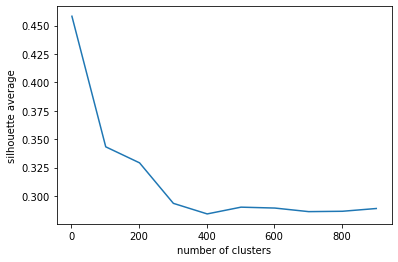

In [11]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [13]:
number_of_clusters =  200
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 96       4
136      5
162      6
8        6
80       6
76       7
170      8
128      8
81       9
197      9
108      9
104     10
33      11
141     11
175     11
168     11
38      11
187     11
2       12
100     12
48      12
166     12
97      13
178     13
93      13
9       14
73      15
171     15
188     15
82      16
118     17
36      17
143     17
32      18
88      19
124     19
189     19
181     19
169     19
173     19
137     20
71      20
105     21
148     21
92      21
195     22
184     22
49      22
177     23
190     25
72      25
54      26
1       26
27      26
31      26
158     26
83      26
44      27
15      27
198     27
153     27
174     27
130     28
179     29
70      29
131     29
194     29
119     30
3       31
182     32
84      33
138     33
142     33
86      34
115     34
120     34
52      34
57      34
109     34
56      34
191     34
103     35
89      36
85      37
22      37
58      37
156     38
135     39
183     39
154  

In [18]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [19]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/home/franko/anaconda3/envs/critical/lib/python3.6/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

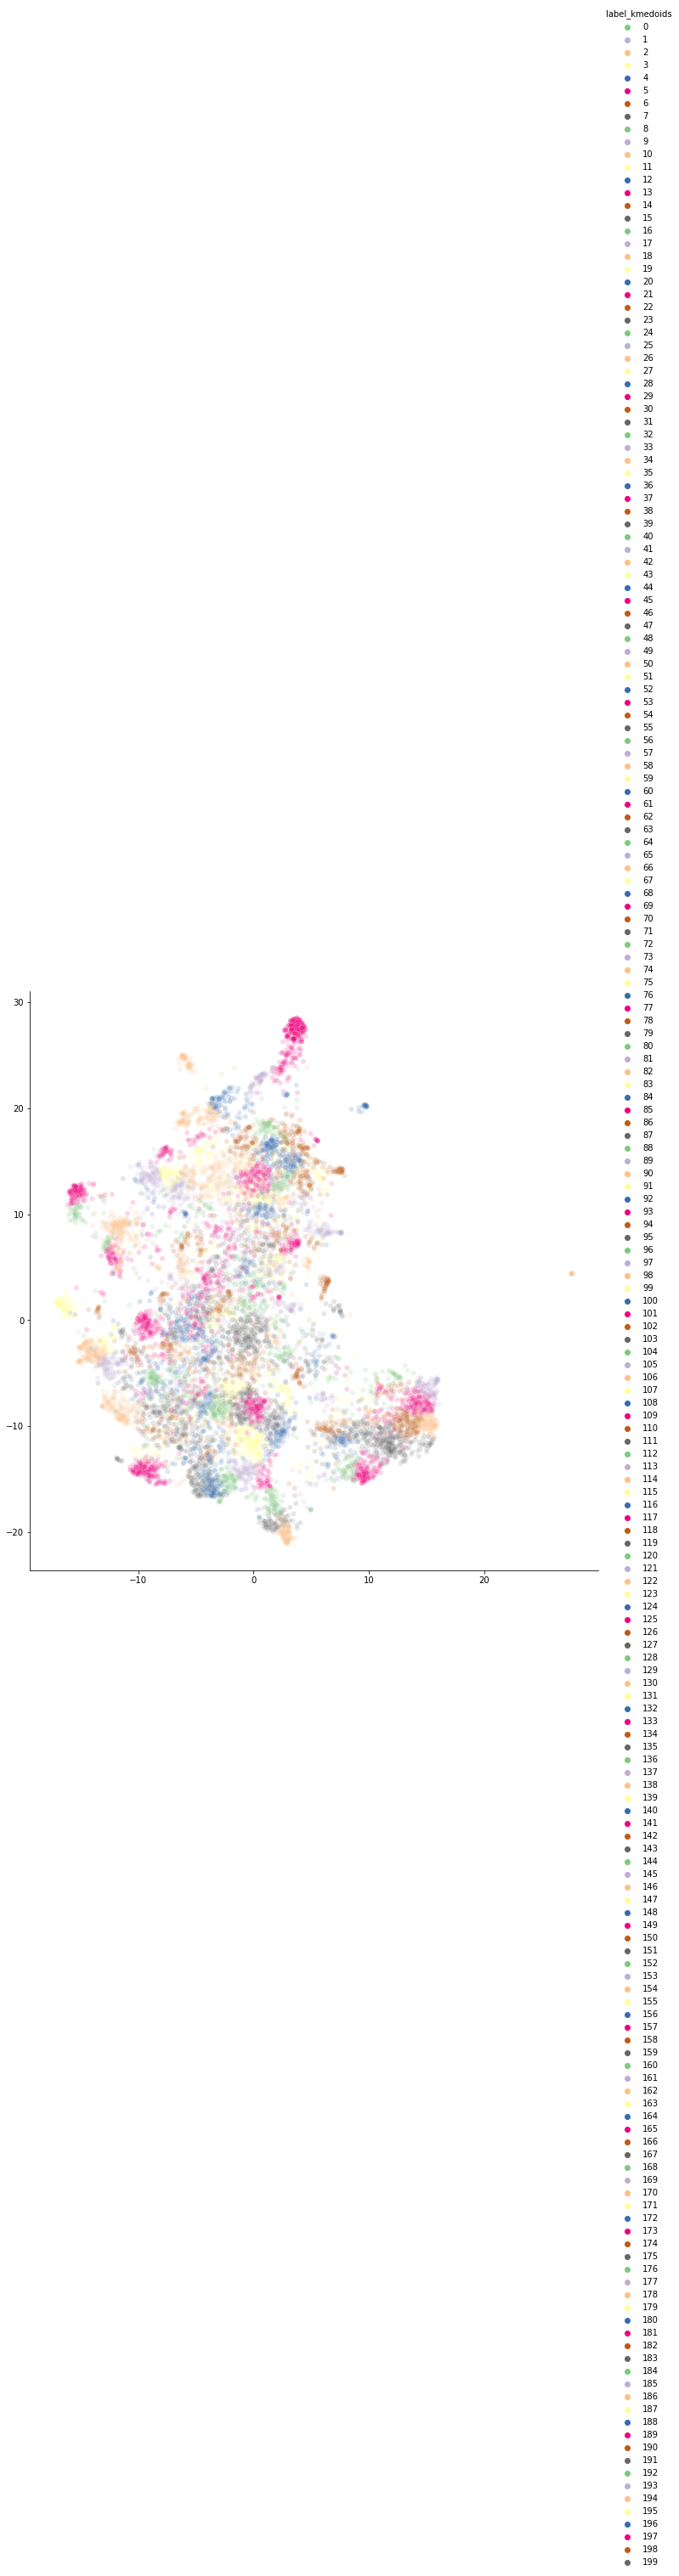

In [20]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

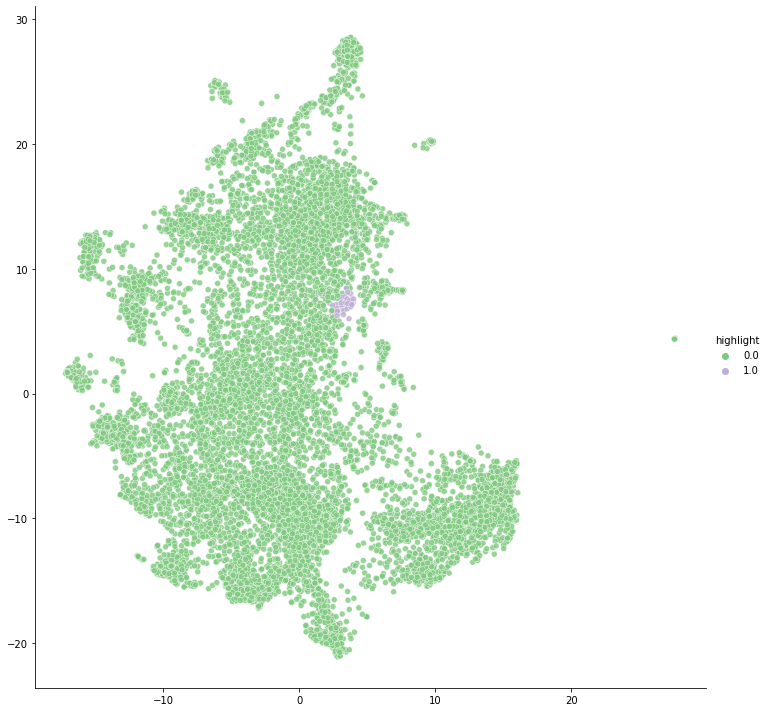

In [28]:
## Choose a cluster to higlight:
cluster_num = 77

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [29]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
9189,2020-09-30 16:24:47,SteriCraft,"Please make a video about the advantages of nuclear energy to improve our emissions, and make eletric based transportation feasable ! :D",0,"Please make a video about the advantages of nuclear energy to improve our\nemissions, and make eletric based transportation feasable ! :D\n\n",-1.0,0,0.000000e+00,0.0
1333,2020-10-18 19:33:39,01 Angelo Michayle Theodore,@Darthjoni who have summon the BRUH MASTER,1,@ who have summon the BRUH MASTER\n\n,-1.0,1,0.000000e+00,0.0
4199,2020-10-04 20:22:47,Rick TD,"@Don’t Look What do the acronyms OLR, UHI, UAH, RSS, TSI and GCR stand for pertaining to climate science ?",1,"@ What do the acronyms OLR, UHI, UAH, RSS, TSI and GCR stand for\npertaining to climate science ?\n\n",-1.0,2,0.000000e+00,0.0
7037,2020-10-01 09:57:13,Impish Fou,"Ahahhah<br />Scientist :<br />Climate is gonna bring apocalypse <br />Florida Karens : The earth is flat, so ice caps wont melt, you fascist. You are sheep",0,"Ahahhah \nScientist : \nClimate is gonna bring apocalypse \nFlorida Karens : The earth is flat, so ice caps wont melt, you fascist. You\nare sheep\n\n",-1.0,3,0.000000e+00,0.0
2061,2020-10-10 04:17:57,dru70292,"Not only that but CO2 is and essential part of our atmosphere, without it we would have no plants to make oxygen for us. Such a shame to see this channel ignore science that disagrees with the mainstream narrative.",1,"Not only that but CO2 is and essential part of our atmosphere, without it we\nwould have no plants to make oxygen for us. Such a shame to see this channel\nignore science that disagrees with the mainstream narrative.\n\n",-1.0,4,0.000000e+00,0.0
3035,2020-10-10 17:15:51,Matthew Murdock,Genius!,1,Genius!\n\n,-1.0,5,0.000000e+00,0.0
3937,2020-10-04 02:24:38,Excelling DEICIDE,"Friendly warning you better be careful for what you advising😳😳😳😳😳 <br />There are LOTS of rich wealthy people (who benefit and have no intention of changing their ways, because they&#39;re super rich).<br />THEY might be CRAZY enough to try and kill U for what you are pretty much advising🤔✅💯",0,"Friendly warning you better be careful for what you advising😳😳😳😳😳 \nThere are LOTS of rich wealthy people (who benefit and have no intention of\nchanging their ways, because they're super rich). \nTHEY might be CRAZY enough to try and kill U for what you are pretty much\nadvising🤔✅💯\n\n",-1.0,6,0.000000e+00,0.0
5167,2020-10-02 10:26:16,KingCosades,"So I was under the impression that solar and wind farms require conventional power plants on the same grid because of how unreliable to resources are, anyone know if this is true?",0,"So I was under the impression that solar and wind farms require conventional\npower plants on the same grid because of how unreliable to resources are,\nanyone know if this is true?\n\n",-1.0,7,0.000000e+00,0.0
3414,2020-10-05 00:12:42,María Burgos,"A video about how capitalism, patriarchy, colonization, warfare are the true villains of his story, not overpopulation.",0,"A video about how capitalism, patriarchy, colonization, warfare are the true\nvillains of his story, not overpopulation.\n\n",-1.0,8,5.960464e-08,0.0
1976,2020-10-10 18:18:33,Matthew Williams,"Well, I&#39;m looking forward to the future Craptopia. But seriously, how about a video about concrete?",0,"Well, I'm looking forward to the future Craptopia. But seriously, how about a\nvideo about concrete?\n\n",-1.0,9,0.000000e+00,0.0


In [30]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  60 mean distance from center:  0.0006723404112563003 Proportion of replies: 15.0
1 number of samples:  26 mean distance from center:  0.0020584235244314186 Proportion of replies: 69.23076923076923
2 number of samples:  12 mean distance from center:  0.0 Proportion of replies: 100.0
3 number of samples:  31 mean distance from center:  0.0018467826521373354 Proportion of replies: 54.83870967741935
4 number of samples:  114 mean distance from center:  0.0005818772933707805 Proportion of replies: 51.75438596491228
5 number of samples:  338 mean distance from center:  0.00027985968245047843 Proportion of replies: 66.86390532544378
6 number of samples:  48 mean distance from center:  0.0010836869478225708 Proportion of replies: 60.416666666666664
7 number of samples:  109 mean distance from center:  0.0008532213541911915 Proportion of replies: 60.55045871559633
8 number of samples:  6 mean distance from center:  0.0034997861803276464 Proportion of replies: 16.6666666666

80 number of samples:  6 mean distance from center:  0.001049041748046875 Proportion of replies: 33.333333333333336
81 number of samples:  9 mean distance from center:  0.0024080276489257812 Proportion of replies: 66.66666666666667
82 number of samples:  16 mean distance from center:  0.0004239380359649658 Proportion of replies: 37.5
83 number of samples:  26 mean distance from center:  0.0022569527573068626 Proportion of replies: 57.69230769230769
84 number of samples:  33 mean distance from center:  0.0012240626347193029 Proportion of replies: 42.42424242424242
85 number of samples:  37 mean distance from center:  0.002104688246618025 Proportion of replies: 43.24324324324324
86 number of samples:  34 mean distance from center:  0.00048542724471190013 Proportion of replies: 64.70588235294117
87 number of samples:  94 mean distance from center:  0.0012233535926498007 Proportion of replies: 56.38297872340426
88 number of samples:  19 mean distance from center:  0.0039357888454105705 Pro

165 number of samples:  46 mean distance from center:  0.0021166128135519102 Proportion of replies: 32.608695652173914
166 number of samples:  12 mean distance from center:  8.742014756535355e-05 Proportion of replies: 33.333333333333336
167 number of samples:  72 mean distance from center:  0.0008174114555004053 Proportion of replies: 87.5
168 number of samples:  11 mean distance from center:  0.0023126602172851562 Proportion of replies: 54.54545454545455
169 number of samples:  19 mean distance from center:  0.002057301389868371 Proportion of replies: 57.89473684210526
170 number of samples:  8 mean distance from center:  0.0019080936908721924 Proportion of replies: 37.5
171 number of samples:  15 mean distance from center:  0.0008849302503222134 Proportion of replies: 40.0
172 number of samples:  49 mean distance from center:  0.0019392187823541462 Proportion of replies: 40.816326530612244
173 number of samples:  19 mean distance from center:  0.0005477353170135757 Proportion of rep

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [31]:
# Choose a cluster to print
cluster_number =  77
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 69
Average Distance from cluster center: 4.0392943e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
6334,2020-10-01 17:13:42,StYle,so basically we are F&#39;ed,0,so basically we are F'ed\n\n,-1.0,77,0.000000e+00,1.0
4524,2020-10-03 07:39:55,RavensEpic,Sir we have struck gold,1,Sir we have struck gold\n\n,-1.0,77,1.192093e-07,1.0
910,2020-10-30 02:02:55,troublemaker,In a nutshell we are toasted :D,0,In a nutshell we are toasted :D\n\n,-1.0,77,1.192093e-07,1.0
4372,2020-10-03 12:20:55,Hamza Ramić,"soooo, we are screwed",0,"soooo, we are screwed\n\n",-1.0,77,1.192093e-07,1.0
3808,2020-10-04 09:19:22,Tribute Streets PIPE Journey,aka we are fcked,0,aka we are fcked\n\n,-1.0,77,1.788139e-07,1.0
3873,2020-10-04 06:07:13,MATA FAKA,"Basically, we&#39;re fucked",0,"Basically, we're fucked\n\n",-1.0,77,2.384186e-07,1.0
3848,2020-10-04 08:02:07,TheSkatersoldier,In a nutshell. We are fcked,0,In a nutshell. We are fcked\n\n,-1.0,77,2.384186e-07,1.0
8273,2020-09-30 20:03:43,João Matheus,"So... We&#39;re bassically f, aren&#39;t we?",0,"So... We're bassically f, aren't we?\n\n",-1.0,77,2.980232e-07,1.0
9369,2020-09-30 15:41:26,Mari's Spot,So... we&#39;re screwed.,0,So... we're screwed.\n\n,-1.0,77,3.576279e-07,1.0
6387,2020-10-01 16:33:23,Alexander Greene,"Yea, we’re fucked...",0,"Yea, we’re fucked...\n\n",-1.0,77,4.768372e-07,1.0


In [43]:
# Choose a cluster to print
cluster_number = 25
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 96
Average Distance from cluster center: 6.8259737e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
5600,2020-10-02 00:40:16,Dingkai Wu,can anyone tell me where I can get nuclear crepe?,0,can anyone tell me where I can get nuclear crepe?\n\n,-1,25,5.960464e-08,0.0
3361,2020-10-05 05:58:10,Vanished,Nuclear energy? Anybody? ; -;,0,Nuclear energy? Anybody? ; -;\n\n,-1,25,1.668930e-06,0.0
5768,2020-10-02 12:37:18,Marvelino,patrolling the mojave makes you wish for a nuclear winter,1,patrolling the mojave makes you wish for a nuclear winter\n\n,-1,25,1.847744e-06,0.0
6649,2020-10-01 14:17:31,Javier Powell,NUCLEAR POWER AND FISSION POWER FTW,0,NUCLEAR POWER AND FISSION POWER FTW\n\n,-1,25,2.205372e-06,0.0
7702,2020-10-01 00:54:19,elpachonisimo SOS,Se need more innovation un nuclear reactors,0,Se need more innovation un nuclear reactors\n\n,-1,25,2.264977e-06,0.0
8510,2020-10-01 12:25:47,Blitz tanker,BACK TO THE NUCLEAR AGE WE SHALL GO,1,BACK TO THE NUCLEAR AGE WE SHALL GO\n\n,-1,25,2.324581e-06,0.0
7083,2020-10-02 06:42:55,Mineral Magnesium,@jaredjeya because of nuclear waste.,1,@ because of nuclear waste.\n\n,-1,25,2.563000e-06,0.0
4461,2020-10-03 07:52:37,X1-Ray,Thorium Reactors?,0,Thorium Reactors?\n\n,-1,25,2.741814e-06,0.0
5761,2020-10-04 03:06:57,Prophecy Rat 2,Atomic Suicide. A technological dream is a biological nightmare.,1,Atomic Suicide. A technological dream is a biological nightmare.\n\n,-1,25,2.741814e-06,0.0
4538,2020-10-03 07:40:47,RavensEpic,Make more nuclear reactors too,1,Make more nuclear reactors too\n\n,-1,25,2.801418e-06,0.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [34]:
#which cluster would you like to assign labels to?
cluster_number = 77
#your label
label_manual = 'doom'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [35]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
6334,2020-10-01 17:13:42,StYle,so basically we are F&#39;ed,0,so basically we are F'ed\n\n,doom,77,0.000000e+00,1.0
4524,2020-10-03 07:39:55,RavensEpic,Sir we have struck gold,1,Sir we have struck gold\n\n,doom,77,1.192093e-07,1.0
910,2020-10-30 02:02:55,troublemaker,In a nutshell we are toasted :D,0,In a nutshell we are toasted :D\n\n,doom,77,1.192093e-07,1.0
4372,2020-10-03 12:20:55,Hamza Ramić,"soooo, we are screwed",0,"soooo, we are screwed\n\n",doom,77,1.192093e-07,1.0
3808,2020-10-04 09:19:22,Tribute Streets PIPE Journey,aka we are fcked,0,aka we are fcked\n\n,doom,77,1.788139e-07,1.0
3873,2020-10-04 06:07:13,MATA FAKA,"Basically, we&#39;re fucked",0,"Basically, we're fucked\n\n",doom,77,2.384186e-07,1.0
3848,2020-10-04 08:02:07,TheSkatersoldier,In a nutshell. We are fcked,0,In a nutshell. We are fcked\n\n,doom,77,2.384186e-07,1.0
8273,2020-09-30 20:03:43,João Matheus,"So... We&#39;re bassically f, aren&#39;t we?",0,"So... We're bassically f, aren't we?\n\n",doom,77,2.980232e-07,1.0
9369,2020-09-30 15:41:26,Mari's Spot,So... we&#39;re screwed.,0,So... we're screwed.\n\n,doom,77,3.576279e-07,1.0
6387,2020-10-01 16:33:23,Alexander Greene,"Yea, we’re fucked...",0,"Yea, we’re fucked...\n\n",doom,77,4.768372e-07,1.0


In [44]:
#which cluster would you like to assign labels to?
cluster_number = 25
#your label
label_manual = 'nuclear'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [45]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
5600,2020-10-02 00:40:16,Dingkai Wu,can anyone tell me where I can get nuclear crepe?,0,can anyone tell me where I can get nuclear crepe?\n\n,nuclear,25,5.960464e-08,0.0
3361,2020-10-05 05:58:10,Vanished,Nuclear energy? Anybody? ; -;,0,Nuclear energy? Anybody? ; -;\n\n,nuclear,25,1.668930e-06,0.0
5768,2020-10-02 12:37:18,Marvelino,patrolling the mojave makes you wish for a nuclear winter,1,patrolling the mojave makes you wish for a nuclear winter\n\n,nuclear,25,1.847744e-06,0.0
6649,2020-10-01 14:17:31,Javier Powell,NUCLEAR POWER AND FISSION POWER FTW,0,NUCLEAR POWER AND FISSION POWER FTW\n\n,nuclear,25,2.205372e-06,0.0
7702,2020-10-01 00:54:19,elpachonisimo SOS,Se need more innovation un nuclear reactors,0,Se need more innovation un nuclear reactors\n\n,nuclear,25,2.264977e-06,0.0
8510,2020-10-01 12:25:47,Blitz tanker,BACK TO THE NUCLEAR AGE WE SHALL GO,1,BACK TO THE NUCLEAR AGE WE SHALL GO\n\n,nuclear,25,2.324581e-06,0.0
7083,2020-10-02 06:42:55,Mineral Magnesium,@jaredjeya because of nuclear waste.,1,@ because of nuclear waste.\n\n,nuclear,25,2.563000e-06,0.0
4461,2020-10-03 07:52:37,X1-Ray,Thorium Reactors?,0,Thorium Reactors?\n\n,nuclear,25,2.741814e-06,0.0
5761,2020-10-04 03:06:57,Prophecy Rat 2,Atomic Suicide. A technological dream is a biological nightmare.,1,Atomic Suicide. A technological dream is a biological nightmare.\n\n,nuclear,25,2.741814e-06,0.0
4538,2020-10-03 07:40:47,RavensEpic,Make more nuclear reactors too,1,Make more nuclear reactors too\n\n,nuclear,25,2.801418e-06,0.0
